In [1]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import librosa
from pesq import pesq
from mir_eval.separation import bss_eval_sources
import torch
from torch import tensor
from torchmetrics.audio import ScaleInvariantSignalNoiseRatio
from matplotlib.ticker import MultipleLocator, FormatStrFormatter


In [2]:
# basic parameters
fs = 16000
Second = 4.9
reverberation_time_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]
reverberation_time = np.asarray(reverberation_time_list)

# initialize saving vector
pesq_soucre_predict_Wiener = np.zeros(len(reverberation_time))
pesq_soucre_predict_RLS = np.zeros(len(reverberation_time))
pesq_soucre_predict_Kalman = np.zeros(len(reverberation_time))
pesq_source_DAS = np.zeros(len(reverberation_time))
pesq_y_nodelay = np.zeros(len(reverberation_time))
pesq_y_wpe = np.zeros(len(reverberation_time))

sdr_soucre_predict_Wiener = np.zeros(len(reverberation_time))
sdr_soucre_predict_RLS = np.zeros(len(reverberation_time))
sdr_soucre_predict_Kalman = np.zeros(len(reverberation_time))
sdr_source_DAS = np.zeros(len(reverberation_time))
sdr_y_nodelay = np.zeros(len(reverberation_time))
sdr_y_wpe = np.zeros(len(reverberation_time))

for i in range(len(reverberation_time)) :
    # assemble filename
    filename_soucre_predict_Wiener = 'wav./source_predict_partial_Wiener_MINT_' + str(reverberation_time[i]) + '.wav'
    filename_soucre_predict_RLS = 'wav./source_predict_partial_RLS_MINT_' + str(reverberation_time[i]) + '.wav'
    filename_soucre_predict_Kalman = 'wav./source_predict_partial_Kalman_MINT_' + str(reverberation_time[i]) + '.wav'
    filename_source_DAS = 'wav./source_DAS_partial_' + str(reverberation_time[i]) + '.wav'
    filename_y_nodelay = 'wav./y_nodelay_partial_' + str(reverberation_time[i]) + '.wav'
    filename_y_wpe = 'wav./y_wpe_partial_' + str(reverberation_time[i]) + '.wav'

    # use librosa to load .wav
    source, fs= librosa.load('wav./source.wav', sr=fs, mono=True, offset=0.0, duration=Second, dtype=np.float32)
    soucre_predict_Wiener, fs= librosa.load(filename_soucre_predict_Wiener, sr=fs, mono=True, offset=0.0, duration=Second, dtype=np.float32)
    soucre_predict_RLS, fs= librosa.load(filename_soucre_predict_RLS, sr=fs, mono=True, offset=0.0, duration=Second, dtype=np.float32)
    soucre_predict_Kalman, fs= librosa.load(filename_soucre_predict_Kalman, sr=fs, mono=True, offset=0.0, duration=Second, dtype=np.float32)
    source_DAS, fs= librosa.load(filename_source_DAS, sr=fs, mono=True, offset=0.0, duration=Second, dtype=np.float32)
    y_nodelay, fs= librosa.load(filename_y_nodelay, sr=fs, mono=True, offset=0.0, duration=Second, dtype=np.float32)
    y_wpe, fs= librosa.load(filename_y_wpe, sr=fs, mono=True, offset=0.0, duration=Second, dtype=np.float32)

    # compute PESQ
    pesq_soucre_predict_Wiener[i] = pesq(fs, source, soucre_predict_Wiener , 'nb')
    pesq_soucre_predict_RLS[i] = pesq(fs, source, soucre_predict_RLS, 'nb')
    pesq_soucre_predict_Kalman[i] = pesq(fs, source, soucre_predict_Kalman , 'nb')
    pesq_source_DAS[i] = pesq(fs, source, source_DAS, 'nb')
    pesq_y_nodelay[i] = pesq(fs, source, y_nodelay, 'nb')
    pesq_y_wpe[i] = pesq(fs, source, y_wpe, 'nb')

    # compute SDR
    (sdr_soucre_predict_Wiener[i], sir, sar, perm) = bss_eval_sources(source, soucre_predict_Wiener)
    (sdr_soucre_predict_RLS[i], sir, sar, perm) = bss_eval_sources(source, soucre_predict_RLS)
    (sdr_soucre_predict_Kalman[i], sir, sar, perm) = bss_eval_sources(source, soucre_predict_Kalman)
    (sdr_source_DAS[i], sir, sar, perm) = bss_eval_sources(source, source_DAS)
    (sdr_y_nodelay[i], sir, sar, perm) = bss_eval_sources(source, y_nodelay)
    (sdr_y_wpe[i], sir, sar, perm) = bss_eval_sources(source, y_wpe)


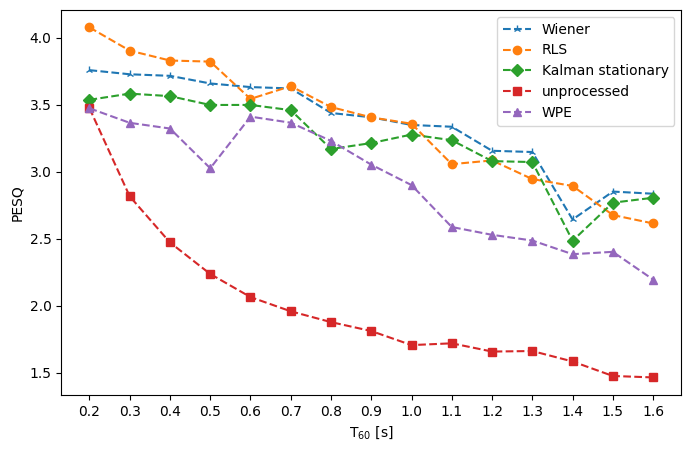

In [3]:
# plot PESQ vs T60
fig1 = plt.figure(figsize=(8, 5))
ax1 = fig1.add_subplot()
ax1.plot(reverberation_time, pesq_soucre_predict_Wiener, linestyle='--', marker='2')
ax1.plot(reverberation_time, pesq_soucre_predict_RLS, linestyle='--', marker='o')
ax1.plot(reverberation_time, pesq_soucre_predict_Kalman, linestyle='--', marker="D")
# ax1.plot(reverberation_time, pesq_source_DAS, linestyle='--', marker='^')
ax1.plot(reverberation_time, pesq_y_nodelay, linestyle='--', marker='s')
ax1.plot(reverberation_time, pesq_y_wpe-0.5, linestyle='--', marker='^')
ax1.grid(False)
ax1.set_xticks(reverberation_time_list)
ax1.set_xlabel('T$_{60}$ [s]') 
ax1.set_ylabel('PESQ')
ax1.legend(['Wiener', 'RLS', 'Kalman stationary', 'unprocessed', 'WPE'])

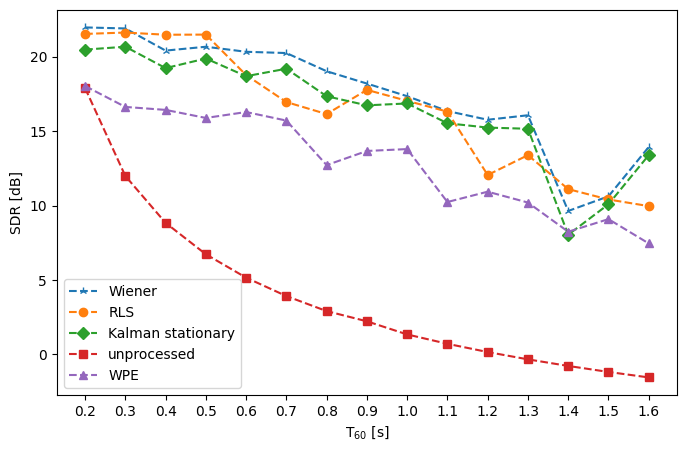

In [4]:
# plot SDR vs T60
fig2 = plt.figure(figsize=(8, 5))
ax2 = fig2.add_subplot()
ax2.plot(reverberation_time, sdr_soucre_predict_Wiener, linestyle='--', marker='2')
ax2.plot(reverberation_time, sdr_soucre_predict_RLS, linestyle='--', marker='o')
ax2.plot(reverberation_time, sdr_soucre_predict_Kalman, linestyle='--', marker="D")
# ax2.plot(reverberation_time, sdr_source_DAS, linestyle='--', marker='^')
ax2.plot(reverberation_time, sdr_y_nodelay, linestyle='--', marker='s')
ax2.plot(reverberation_time, sdr_y_wpe-7, linestyle='--', marker='^')
ax2.grid(False)
ax2.set_xticks(reverberation_time_list)
ax2.set_xlabel('T$_{60}$ [s]') 
ax2.set_ylabel('SDR [dB]')
ax2.legend(['Wiener', 'RLS', 'Kalman stationary', 'unprocessed', 'WPE'])